# AutoML - Praca Domowa nr 2

In [3]:
from typing import Tuple, Any, Callable, Iterable
from datetime import datetime
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [4]:
# for BayesSearchCV to work:
np.int = np.int64

# Wczytywanie danych

In [5]:
x_train = pd.read_csv('data/artificial_train.data',  sep=' ', header=None)
x_train = x_train.iloc[:, :-1]

In [6]:
y_train = pd.read_csv('data/artificial_train.labels', header=None)
# update labelling for XGB to work
y_train[y_train == -1] = 0
# convert to a flat array for RF to work
y_train = y_train.values.ravel()

In [7]:
x_test = pd.read_csv('data/artificial_test.data',  sep=' ', header=None)
x_test = x_test.iloc[:, :-1]

In [8]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 500 entries, 0 to 499
dtypes: int64(500)
memory usage: 7.6 MB


In [12]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Columns: 500 entries, 0 to 499
dtypes: int64(500)
memory usage: 2.3 MB


In [11]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 1000]
 [   1 1000]]


## Podział na zbiór treningowy i walidacyjny

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=123)

## Funkcja do liczenia balanced accuracy

In [21]:
def calculate_balanced_accuracy(y_true_, y_pred_):
    cm = confusion_matrix(y_true_, y_pred_)
    sensitivity = cm[1,1] / (cm[1,0] + cm[1,1]) # True Positive rate
    specificity = cm[0,0] / (cm[0,0] + cm[0,1]) # True Negative rate
    balanced_accuracy = (sensitivity + specificity) / 2
    return balanced_accuracy

## Funkcja do zapisywania predykcji

In [22]:
def save_prediction(pred_func: Callable[[pd.DataFrame], Iterable], 
                    save_path: str,
                    test_data: pd.DataFrame) -> None:
    # predictions have to be probabilities of an observation belonging to each class
    prediction = pred_func(test_data)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, 'w') as file:
        file.write('"313361_313445"\n')
        for pred_val in prediction:
            # the second element should be a probability of belonging to class 1
            file.write(f'{pred_val[1]}\n')

# 1. Wariant ręczny

## Ograniczenie liczby kolumn na bazie niskiej korelacji ze zmienną celu w danych treningowych

In [23]:
train_data = x_train.copy()
train_data['target'] = y_train.copy()

correlation_matrix = train_data.corr(method='spearman')

num_features_to_remove = int(0.25 * len(correlation_matrix))
low_corr_features = correlation_matrix['target'].abs().nsmallest(num_features_to_remove).index

train_data_filtered = train_data.drop(low_corr_features, axis=1)
x_train_filtered = train_data_filtered.drop(columns=['target']) 

In [24]:
x_val_filtered = x_val.drop(low_corr_features, axis=1)

In [25]:
x_test_filtered = x_test.drop([int(f) for f in low_corr_features], axis=1)

## Wybranie wymiarowości przestrzeni w PCA

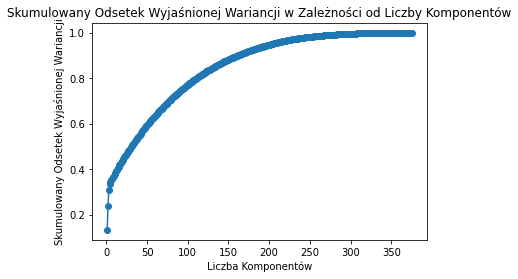

In [26]:
pca = PCA()

pca.fit(x_train_filtered)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance = explained_variance_ratio.cumsum()

plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Liczba Komponentów')
plt.ylabel('Skumulowany Odsetek Wyjaśnionej Wariancji')
plt.title('Skumulowany Odsetek Wyjaśnionej Wariancji w Zależności od Liczby Komponentów')
plt.show()

## Przygotowanie pipeline do preprocessingu

In [27]:
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('pca', PCA(n_components=170)),
    ('scaler', MinMaxScaler())
])

## Pomocnicze funkcje do ręcznego trenowania

In [28]:
def params_tuning(pipeline, params: dict,
                  x_train_: pd.DataFrame, y_train_: pd.Series,
                  n_iter: int = 100,
                  random_state: int = None) -> Tuple[Any, dict]:
    """
    Args:
        pipeline: The pipeline that contains a model named 'model', whose 
            hyperparameters are to be optimized.
        params: A dictionary containing the hyperparameters to be tuned with 
            corresponding value ranges or lists.
        x_train_: The input features for training the model.
        y_train_: The target values for training the model.
        n_iter: The number of random combinations of hyperparameters to try.
        random_state: Seed for random number generation, ensuring reproducibility.

    Returns:
        A tuple containing the following:
        - The best estimator with the tuned hyperparameters.
        - A dictionary of the best hyperparameters found during the search.
    """
    params_optimiser = BayesSearchCV(
        estimator=pipeline,
        search_spaces=params,
        n_iter=n_iter, 
        scoring='balanced_accuracy',
        random_state=random_state,
        cv=5, 
        n_jobs=-1,
        verbose=2,
    )
    params_optimiser.fit(x_train_, y_train_)
    return params_optimiser.best_estimator_, params_optimiser.best_params_

In [29]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

    
def save_params_dict(params: dict, base_name: str, base_path = './params'):
    timestamp_ = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename_ = f'{base_name}_{timestamp_}.json'
    path = os.path.join(base_path, filename_)
    os.makedirs(base_path, exist_ok=True)
    with open(path, 'w') as file:
        json.dump(params, file, indent=2, cls=NumpyEncoder)


def read_params_dict(filename_: str) -> dict:
    with open(filename_) as file:
        result = json.load(file)
    return result

## XGBoost

In [30]:
from xgboost import XGBClassifier

In [31]:
params_xgb = {
    "model__n_estimators": Integer(100, 2000),
    "model__eta": Real(0.001, 0.4),
    "model__subsample": Real(0.1, 1.),
    "model__max_depth": Integer(3, 250),
    "model__min_child_weight": Real(1, 2^7),
    "model__colsample_bytree": Real(0.1, 1.),
}

In [32]:
xgb_pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', XGBClassifier()),
])

### Bayes: 100 iterations

In [ ]:
xgb_model, xgb_params = params_tuning(
    pipeline=xgb_pipe,
    params=params_xgb,
    x_train_=x_train_filtered,
    y_train_=y_train,
    random_state=24,
    n_iter=20,
)

In [37]:
y_pred = xgb_model.predict(x_train_filtered)
calculate_balanced_accuracy(y_train, y_pred)

1.0

In [38]:
y_pred = xgb_model.predict(x_val_filtered)
calculate_balanced_accuracy(y_val, y_pred)

0.7751879699248121

In [ ]:
# save params for later
save_params_dict(xgb_params, 'xgb_params_100iter')

In [35]:
# load saved params
# CAREFUL: running this will overwrite currently trained model
# change False to True if you really wish to run this
if False:
    xgb_params = read_params_dict('params/xgb_params_100iter_20231227_164032.json')
    xgb_model = Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('model', XGBClassifier()),
    ])
    xgb_model.set_params(**xgb_params)
    xgb_model.fit(x_train_filtered, y_train)

In [36]:
save_prediction(
    pred_func=xgb_model.predict_proba,
    save_path='predictions/xgb_100iter.txt',
    test_data=x_test_filtered,
)

## RandomForestClassifier

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
params_rf = {
    "model__n_estimators": Integer(100, 2000),
    "model__max_depth": Integer(3, 250),
    "model__max_features": Real(1e-6, 1),
    "model__max_samples": Real(1e-6, 1),
    "model__min_samples_leaf": Real(0.1, 0.5),
}

In [41]:
rf_pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', RandomForestClassifier()),
])

In [ ]:
rf_model, rf_params = params_tuning(
    pipeline=rf_pipe,
    params=params_rf,
    x_train_=x_train_filtered,
    y_train_=y_train,
    random_state=26,
    n_iter=100,
)

In [45]:
y_pred = rf_model.predict(x_train_filtered)
calculate_balanced_accuracy(y_train, y_pred)

0.6278481012658228

In [46]:
y_pred = rf_model.predict(x_val_filtered)
calculate_balanced_accuracy(y_val, y_pred)

0.6395989974937344

In [31]:
save_params_dict(rf_params, 'rf_params')

In [43]:
# load saved params
# CAREFUL: running this will overwrite currently trained model
# change False to True if you really wish to run this
if False:
    rf_params = read_params_dict('params/rf_params_20231226_165340.json')
    rf_model = Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('model', RandomForestClassifier()),
    ])
    rf_model.set_params(**rf_params)
    rf_model.fit(x_train_filtered, y_train)

In [44]:
save_prediction(rf_model.predict_proba,"predictions/rf_proba.txt", x_test_filtered)

## Sieć neuronowa

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [38]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        layer_1 = 512
        layer_2 = 512
        layer_out = 2
        self.network = nn.Sequential(
            nn.Linear(input_size, layer_1),
            nn.ReLU(),
            nn.Linear(layer_1, layer_2),
            nn.ReLU(),
            nn.Linear(layer_2, layer_out),
            nn.Softmax(dim=1),
        )
    
    def forward(self, x):
        return self.network(x)

In [41]:
def train_model(model, criterion, optimizer, train_loader, num_epochs, x_train, y_train, x_val, y_val):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    accuracy_val = []
    accuracy_train = []

    for epoch in range(1, num_epochs + 1):
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.reshape(-1, 1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}/{num_epochs}')
            print('Train loss: ', loss.item())

            x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
            x_val_tensor = torch.tensor(x_val, dtype=torch.float32).to(device)

            y_pred_train = model(x_train_tensor).reshape(-1).cpu().detach().numpy().round()
            y_pred_val = model(x_val_tensor).reshape(-1).cpu().detach().numpy().round()

            train_balanced_acc = calculate_balanced_accuracy(y_train, y_pred_train)
            val_balanced_acc = calculate_balanced_accuracy(y_val, y_pred_val)

            print(f'Train balanced accuracy: {train_balanced_acc:.4f}')
            print(f'Validation balanced accuracy: {val_balanced_acc:.4f}')
            print()

            accuracy_train.append(train_balanced_acc)
            accuracy_val.append(val_balanced_acc)

    # Save network after training
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    model_path = os.path.join('torch_network', f'mlp_model_{timestamp}_{epoch}.pth')
    torch.save(model.state_dict(), model_path)

    return accuracy_train, accuracy_val

In [40]:
x_train_processed = preprocessing_pipeline.fit_transform(x_train)
x_val_processed = preprocessing_pipeline.transform(x_val)
x_test_processed = preprocessing_pipeline.transform(x_test)

x_train_tensor = torch.tensor(x_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

x_val_tensor = torch.tensor(x_val_processed, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

x_test_tensor = torch.tensor(x_test_processed, dtype=torch.float32)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [46]:
# przykladowe wywolanie:
mlp_model = MLP(input_size=170)
criterion = nn.BCELoss()
optimizer = optim.SGD(mlp_model.parameters(), lr=0.01, weight_decay=0.01)
acc_train, acc_val = train_model(mlp_model, criterion, optimizer, train_loader, num_epochs=10000, 
                        x_train=x_train_processed, y_train=y_train, x_val=x_val_processed, 
                        y_val=y_val)

In [ ]:
save_prediction(mlp_model.predict_proba,"predictions/mlp_proba.txt", x_test_processed)

# 2. Wariant AutoML

## MLJar

In [47]:
from supervised import AutoML as AutoMLJar

In [48]:
mljar_predictor = AutoMLJar(
    mode='Compete',
    results_path='mljar_results/',
    total_time_limit=60 * 60 * 24,
    random_state=24,
    eval_metric='logloss',
)

In [ ]:
mljar_predictor.fit(x_train, y_train)

In [1]:
y_pred = mljar_predictor.predict(x_train)
calculate_balanced_accuracy(y_train, y_pred)

In [ ]:
y_pred = mljar_predictor.predict(x_val)
calculate_balanced_accuracy(y_val, y_pred)

In [ ]:
save_prediction(
    pred_func=mljar_predictor.predict_proba,
    save_path='predictions/mljar.txt',
    test_data=x_test,
)

## AutoGluon

In [8]:
from autogluon.tabular import TabularPredictor

In [11]:
data_train_gluon = x_train.copy()
data_train_gluon['target'] = y_train
data_val_gluon = x_val.copy()
data_val_gluon['target'] = y_val

In [12]:
gluon_predictor = TabularPredictor(label='target', eval_metric='balanced_accuracy')
gluon_predictor.fit(data_train_gluon, presets='high_quality', time_limit=60*60*24)

In [14]:
y_pred = gluon_predictor.predict(x_train)
calculate_balanced_accuracy(y_train, y_pred)

In [15]:
y_pred = gluon_predictor.predict(x_val)
calculate_balanced_accuracy(y_val, y_pred)

In [12]:
# local loading gluon
gluon_predictor = TabularPredictor.load("ag-20231229_201739")
y_pred = gluon_predictor.predict(x_test)
#best score on val set 0.870863498584634


############################## WARNING ##############################
	Predictor Version: 1.0.0
	Current Version:   1.0.1b20231205
############################## WARNING ##############################



AssertionError: AssertionError: Predictor was created on version 1.0.0 but is being loaded with version 1.0.1b20231205. Please ensure the versions match to avoid instability. While it is NOT recommended, this error can be bypassed by specifying `require_version_match=False`.

In [13]:
y_pred

NameError: NameError: name 'y_pred' is not defined

In [ ]:
save_prediction(
    pred_func=gluon_predictor.predict_proba,
    save_path='predictions/gluon.txt',
    test_data=x_test,
)